# P5 Starter - Time Series Analysis 

### Statistical Modeling to Deep Learning

##  Imports & Sanity Check (Do NOT Change)

In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm.notebook import tqdm
import statsmodels.api as sm # PACF, ACF
from typing import Tuple, List

# Viz:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/helper/helper.py
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/oil.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/stores.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/train.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/test.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/transactions.csv


In [2]:
import importlib.util
import sys

file_path = '/kaggle/input/helper/helper.py'  # full path to the file

spec = importlib.util.spec_from_file_location("helper", file_path)
helper = importlib.util.module_from_spec(spec)
sys.modules["helper"] = helper
spec.loader.exec_module(helper)

## Helper Utilities. Read the Function names at least so that you are not re-writing code

* **make_submission**: Helps you convert your predictions to competition submission ready files.
* **rmsle**: Implementation of the metric used to evaluate your score on the leaderboard.
* **lgbm_rmsle**: Definition that can be used to do train-val type training while printing metric scores.
* **data import**: Imports the necessary files into the notebook
* **preprocess_holidays**: Performs some necessary cleaning on the holiday dataset
* **preprocess_test_train**: Performs some necessary cleaning on the test and train dataset

## Load the data (Do NOT Change)

In [3]:
#########################
# DO NOT CHANGE
#########################
train, test, stores, transactions, oil, holidays = helper.data_import()
holidays, regional, national, local, events, work_day, _, _, _ = helper.preprocess_holidays(holidays)

## Section 1: EDA & Feature Engineering

In [45]:
data = pd.concat([train.assign(dataset='train'), test.assign(dataset='test')], sort=False)
merged_df = data.copy()


/tmp/ipykernel_31/2296726811.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



### Q1 Left join transaction to train and then print the Spearman Correlation between Total Sales and Transactions.

In [46]:
# TODO - q1
df1 = merged_df.merge(transactions, on=['date','store_nbr'], how='left')
grp = df1.groupby(['date','store_nbr']).agg(
    total_sales=('sales','sum'),
    avg_transactions=('transactions','mean')
).reset_index()
corr = grp[['total_sales','avg_transactions']].corr(method='spearman').iloc[0,1]
print(f"Spearman Correlation: {corr:.4f}")


Spearman Correlation: 0.8027


### Q2 Plot an 'ordinary least squares' trendline between transactions and sales to verify the spearman correlation value in Q1. [0.1 Points]

In [51]:
# TODO - q2
import plotly.graph_objects as go
import statsmodels.formula.api as smf
model = smf.ols('total_sales ~ avg_transactions', data=grp).fit()
fig = px.scatter(grp, x='avg_transactions', y='total_sales', trendline='ols',
                 labels={'avg_transactions':'Avg Transactions','total_sales':'Total Sales'},
                 title='OLS Trendline: Transactions vs Sales')
fig.write_html('/kaggle/working/q2.html')



### Q3 Plot these line charts in the notebook:

A) Transactions vs Date (all stores color coded in the same plot) 

B) Average monthly transactions

 C) Average Transactions on the days of the wee)


In [52]:
# TODO - q3 - Plot A
fig = px.line(grp, x='date', y='avg_transactions', color=grp['store_nbr'].astype(str),
              labels={'date':'Date','avg_transactions':'Avg Transactions','color':'Store'},
              title='Transactions vs Date (All Stores)')
fig.write_html('/kaggle/working/q3a.html')

In [53]:
# TODO - q3 - Plot B
gr_month = grp.set_index('date').resample('M')['avg_transactions'].mean().reset_index()
fig = px.line(gr_month, x='date', y='avg_transactions',
              labels={'date':'Month','avg_transactions':'Avg Transactions'},
              title='Average Monthly Transactions')
fig.update_xaxes(tickformat='%Y-%m')
fig.write_html('/kaggle/working/q3b.html')


/tmp/ipykernel_31/4137331111.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [54]:
# TODO - q3 - Plot C
gr_week = grp.copy()
gr_week['dow'] = gr_week['date'].dt.day_name()
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
agg_week = gr_week.groupby('dow')['avg_transactions'].mean().reindex(order).reset_index()
fig = px.bar(agg_week, x='dow', y='avg_transactions',
             labels={'dow':'Day of Week','avg_transactions':'Avg Transactions'},
             title='Avg Transactions by Day of Week')
fig.write_html('/kaggle/working/q3c.html')



### Q4 Use pandas' in-build (linear) interpolation to impute the missing oil values then overlay the imputed feature over the original.

Your new feature column should be called: `dcoilwtico_interpolated`

In [56]:
# Interpolate. 

# Plot

oil_sorted = oil.sort_values('date')
oil_sorted['dcoilwtico_interpolated'] = oil_sorted['dcoilwtico'].interpolate(method='linear')
fig = go.Figure()
fig.add_trace(go.Scatter(x=oil_sorted.date, y=oil_sorted.dcoilwtico, name='Original'))
fig.add_trace(go.Scatter(x=oil_sorted.date, y=oil_sorted.dcoilwtico_interpolated, name='Interpolated'))
fig.update_layout(title='Oil Price: Original vs Interpolated', xaxis_title='Date', yaxis_title='Price')
fig.write_html('/kaggle/working/q4.html')

### Q5 Again, left join oil on the dataframe above and report the spearman correlation between oil and sales and oil and transactions

In [57]:
# Find correlation with sales & transactions

grp2 = grp.merge(oil_sorted[['date','dcoilwtico_interpolated']], on='date', how='left')
cor_sales = grp2['total_sales'].corr(grp2['dcoilwtico_interpolated'], method='spearman')
cor_trans = grp2['avg_transactions'].corr(grp2['dcoilwtico_interpolated'], method='spearman')
print(f"Spearman Correlation (Oil vs Sales): {cor_sales:.4f}")
print(f"Spearman Correlation (Oil vs Transactions): {cor_trans:.4f}")


Spearman Correlation (Oil vs Sales): -0.3054
Spearman Correlation (Oil vs Transactions): 0.0380


### Q6 Report the top-3 highest negative correlations between oil and sales of a particular product family. Now think whether oil should be discarded as a feature?

In [58]:
# Calculate all correlations

# Report the top 3

df3 = merged_df.merge(oil_sorted[['date','dcoilwtico_interpolated']], on='date', how='left')
fam = df3.groupby(['family','date']).sales.sum().reset_index()
fam = fam.merge(oil_sorted[['date','dcoilwtico_interpolated']], on='date')
corrs = fam.groupby('family').apply(lambda d: d['sales'].corr(d['dcoilwtico_interpolated'], method='spearman'))
corrs = corrs.dropna().sort_values().head(3)
print(corrs)


family
HOME AND KITCHEN II   -0.782246
MAGAZINES             -0.703602
BEVERAGES             -0.634068
dtype: float64


/tmp/ipykernel_31/3279910300.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Q7. Implement the One hot encode function 

You just have to finish the one-hot encoder function definition for this one.

In [61]:
from typing import Tuple, List

def one_hot_encoder(df: pd.DataFrame, nan_as_category: bool=True) -> Tuple[pd.DataFrame, List[str]]:
    cats = df.select_dtypes(include=['object','category']).columns.tolist()
    df_enc = pd.get_dummies(df, columns=cats, dummy_na=nan_as_category)
    df_enc.columns = df_enc.columns.str.replace(' ', '_')
    new_cols = []
    for f in cats:
        prefix = f + '_'
        # After replacement, spaces in f also replaced
        f_clean = f.replace(' ', '_')
        prefix = f_clean + '_'
        new_cols.extend([col for col in df_enc.columns if col.startswith(prefix)])
    return df_enc, new_cols


In [62]:
#########################
# DO NOT CHANGE. 
# NOTE: Run this after you have implemented the one_hot_encoder function above.
#########################

train, test = helper.preprocess_test_train(merged_df, one_hot_encoder, stores)

## Section 2

### Q8. EMA

Forecast window should be >=15 days since the test set is 15 days. **For this question use 16 as the forecast window**

In [15]:
# Train EMAs for each family per store (pandas has an inbuilt ema function!)

In [66]:
# Make the predictions

# Use the make_submission utility function provided to save a submission CSV. 

# Submit to competition and note your RMSLE score somewhere for this model type.

# NOTE - 1: You still need to go on the right panel and click submit 
# (make_submission will NOT submit to competition -> It just makes a submission ready file)
# NOTE - 2: Ensure that you are not overwriting your submission.csv file in subsequent cells.

# Use the make_submission utility function provided to save a submission CSV.

# helper.make_submission(test_preds=[], file_name="EMA_results.csv")
preds = []
for (store,fam), group in merged_df[merged_df.dataset=='train'].groupby(['store_nbr','family']):
    ser = group.set_index('date')['sales']
    ema_last = ser.ewm(span=16).mean().iloc[-1]
    preds.extend([ema_last]*16)
helper.make_submission(preds, file_name='EMA_results.csv')


### Q9. PACF and ACF

Use lib sm 

(statsmodel.api is already imported as sm)

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

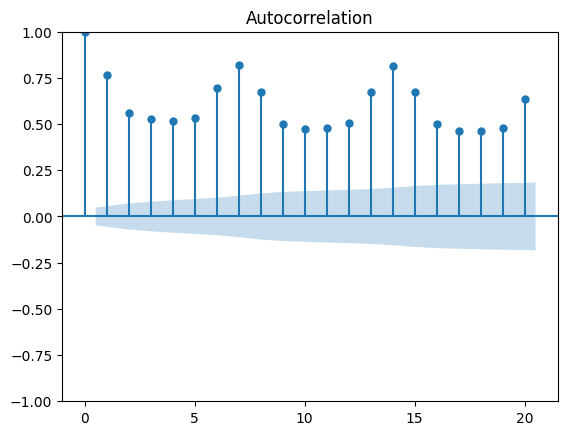

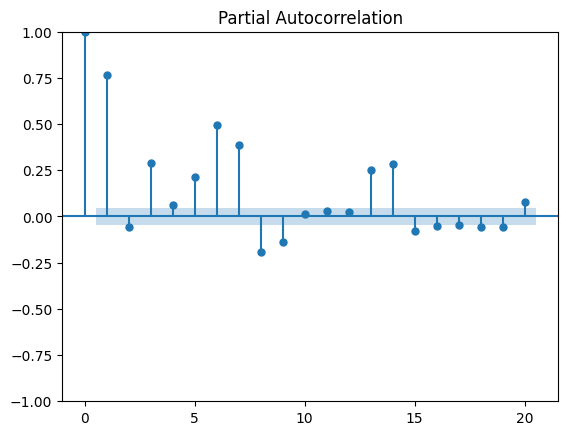

In [67]:
# 1. Group by date
daily = merged_df[merged_df.dataset=='train'].groupby('date')['sales'].sum()
fig_acf = sm.graphics.tsa.plot_acf(daily, lags=20)
fig_pacf = sm.graphics.tsa.plot_pacf(daily, lags=20)


In [ ]:
- The ACF drops off slowly and spikes at lags 7 and 14, showing that the data still carries a trend and a weekly cycle, so it isn’t yet stationary. The PACF has one big bar at lag 0, smaller bumps again at 7 and 14, and a negative bar at lag 2, which points to a short-term AR(1) effect, a weekly seasonal AR term, and possibly an MA(1) term. 

### Q10. ADF Test -> ARIMA

#### Differencing technique
This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data.

In [68]:
# 1. Compute and store the diff series

# 2. Drop NA or any other erroneous values.
diff = daily.diff().dropna()


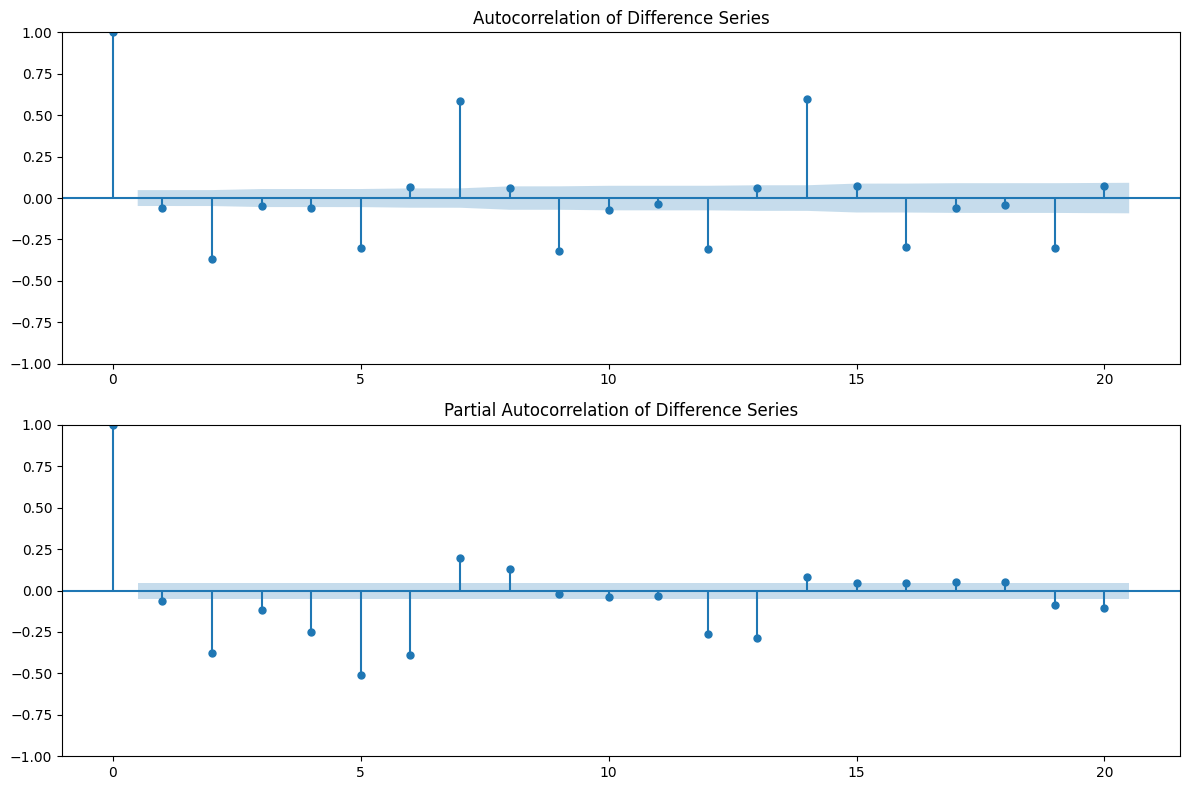

In [70]:

# Plot the ACF

##########
# TODO: Your plot code goes here:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation of Difference Series')
plot_pacf(diff, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation of Difference Series')
plt.tight_layout()
plt.show()
##########

##########


### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [21]:
from statsmodels.tsa.stattools import adfuller

In [71]:
# 1. Perform the ADF test

# 2. Extract the test statistics and p-value

# 3. Print these values
adf_stat, p_value, used_lag, n_obs, crit_values, ic_best = adfuller(diff)
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {p_value:.4e}")
for key, val in crit_values.items():
    print(f"Critical Value ({key}): {val:.4f}")

ADF Statistic: -11.4239
p-value: 6.7681e-21
Critical Value (1%): -3.4343
Critical Value (5%): -2.8633
Critical Value (10%): -2.5677


The ADF statistic is (around) -11.4. This statistic is a negative value and is more negative than the critical values at common significance levels. This suggests strong evidence against the null hypothesis of a unit root, indicating that the time series is stationary.

The p-values (around)  i6.76e-2121, which is a very small value close to zero. Typically, if the p-value is below a chosen significance level (e.g., 0.05), it indicates strong evidence to reject the null hypothesis. In your case, the extremely small p-value suggests strong evidence against the presence of a unit root and supports the stationarity of the time series.

**TODO** Choose the right p, q and d values for your ARIMA model

In [72]:
# TODO: Replace with appropriate p,d,q values for ARIMA
p_arima, d_arima, q_arima = 1, 1, 1


In [74]:
# 1. Get sales series as training data (np array with appropriate dtype)

# 2. Using statsmodel.tsa lib. Initialize an ARIMA model with the p,d,q params you defined. 

# 3. Fit the model
model_arima = sm.tsa.ARIMA(daily, order=(p_arima, d_arima, q_arima)).fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [75]:
# Print the post model fitting summary
print(model_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1669
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22141.105
Date:                Fri, 25 Apr 2025   AIC                          44288.210
Time:                        02:00:15   BIC                          44304.468
Sample:                             0   HQIC                         44294.234
                               - 1669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4420      0.018     24.178      0.000       0.406       0.478
ma.L1         -0.9609      0.008   -123.970      0.000      -0.976      -0.946
sigma2      2.477e+10   1.53e-13   1.62e+23      0.0

In [77]:
# Make predictions & submit to competition using your best model
forecast_steps = 15
preds_arima = model_arima.forecast(steps=forecast_steps)

pred_df = pd.DataFrame({
    'id': test.id.values,     
    'sales': preds_arima      
})
pred_df.to_csv("/kaggle/working/ARIMA_results.csv", index=False)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



ValueError: array length 26730 does not match index length 15

## Section 3

### Q11 Define a validation set. What will be the most appropriate time period for this validation set?

In [27]:
# Get the val set:

### Q12. LightGBM

In [28]:
import lightgbm as lgb

In [29]:
# Process your data to the appropriate dtypes, vars, etc.

In [30]:
# Use the lgb.Dataset method to intialize your dataset iterables.

# 1. Make one for the train set:

# 2. Make another for the val set you defined in Q13:


In [31]:
# Fill the dict with appropriate params:
lgb_params = {'num_leaves': ,
              'learning_rate': ,
              'feature_fraction': ,
              'max_depth': ,
              'verbose': 20,
              'num_boost_round': ,
              'early_stopping_rounds': ,
              'nthread': -1}

SyntaxError: expression expected after dictionary key and ':' (1692572216.py, line 2)

In [ ]:
# Complete the model initialization/train params)
model = lgb.train(lgb_params, ... 

In [ ]:
# 1. Predict the sales value on your val set using the best_iteration recorded by the LGBM
# 2. Compute and print the RMSLE on this val set.

In [ ]:
# 1. Pre-process your test set to appropriate format.
# 2. Predict -> Save using make_submission -> Submit to competition
# 3. Note your RMSLE for LGBM

### Q13. CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
# Fill out missing params for catboost appropriately here:
catboost_params = {
    'iterations': ,           # Number of boosting rounds
    'learning_rate': ,        # Learning rate for gradient boosting
    'depth': ,                   # Depth of each tree
    'loss_function': 'RMSLE',      # Loss function (Root Mean Squared Error for regression)
    'eval_metric': 'RMSLE',        # Evaluation metric
    'random_seed': 42,            # Ensures reproducibility
    'early_stopping_rounds': ,  # Stops training if no improvement after 50 rounds
    'verbose': 100                # Prints training progress every 100 rounds
}

In [ ]:
# 1. Define the model

# 2. Fit


In [ ]:
# 3. Preprocess your test data appropriately

# 4. Make Predictions

In [ ]:
# 5. Use make_submission -> Submit to competition

# 6. Note your RMSLE for this model

### Q14. XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# 1. Initialize model with random state = 42 to be consistent with CatBoost

# 2. Fit


In [ ]:
# 3. Make Predictions.

In [ ]:
# 4. make_submission -> Submit to competition 

# 5. Note your RMSLE 

### Q15. Optuna for automatic hyperparameter optimization

In [ ]:
import optuna
import time

In [ ]:
def objective_lgb(trial):
    # 1. Define the parameter search space
    
    # 2. Create datasets (train, val) for LightGBM

    # 3. Train the model

    # 4. Evaluate on the validation set

    # 5. Return the metric score
    
    pass

# Create Optuna study to minimize the objective function

start = time.time()
# 1. Create the optuna study and specify appropriate direction

# 2. Optimize (pay attention to recommended trials; 50 takes too long)

# 3. Get the best parameters

# 4. Print them.
# print("Best parameters:", best_params)

print("Took:", time.time() - start, "seconds")

In [ ]:
# Make a competition submission using these parameters
# Note these values.

In [ ]:
# Do the same for Catboost

In [ ]:
# Do the same for XGBoost

### Q16. Which out of the three Catboost vs LightGBM vs XGBoost provides the best score? Why do you think this model is more suited to this dataset/problem?

In [ ]:
print("<Your answer goes here>")

## Optional Extra Credit Section - Achieve the lowest score

### Cross Validation Strategies & Ensembling

In [ ]:
# 1. Try different Validation sets 
# 2. Try ensembling different methods used in this assignment together